Classification: Revue avec Python Les problèmes d'apprentissage automatique peuvent être divisés en 3 types: apprentissage supervisé, non supervisé et par renforcement. Alors que l'apprentissage non supervisé consiste à rechercher une structure dans des données non étiquetées, l'apprentissage supervisé prend en charge les données étiquetées et travaille pour prédire et comprendre l'étiquette.

Ici, j'ai l'intention de créer un modèle pour prédire quand un client acceptera un dépôt à terme

1- Exploratory Data Analysis
2- Preprocessing
3- KNN
4- SVM
5- Random Forest
6- Boosting
7- Brief talk about other metrics
8- Interpretability

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report



from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.model_selection import LearningCurve, ValidationCurve, learning_curve


import warnings
warnings.filterwarnings(action="ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Analyse de données :
On va essayer de comprendre notre base de données et les corelation entre nos données.
# Informations sur le client
Age, type de job, education ...
# A propos de la compagne en cours:
Nombre d'appels effectue, type de communication (telephone, cellulaire ...)

##À propos des contacts / campagnes précédents:
-pdays (nombre de jours qui se sont écoulés après que le client a été contacté pour la dernière fois à partir d'une campagne précédente, 999 signifie que le client n'a pas été contacté précédemment)
-précédent (nombre de contacts réalisés avant cette campagne et pour ce client)
-poutcome (résultat de la campagne marketing précédente: 'échec', 'inexistant', 'succès')


In [2]:
df=pd.read_csv('/content/drive/MyDrive/Data/bank.csv')

In [3]:
df.head

<bound method NDFrame.head of        age          job  marital  education  ... pdays  previous poutcome deposit
0       59       admin.  married  secondary  ...    -1         0  unknown     yes
1       56       admin.  married  secondary  ...    -1         0  unknown     yes
2       41   technician  married  secondary  ...    -1         0  unknown     yes
3       55     services  married  secondary  ...    -1         0  unknown     yes
4       54       admin.  married   tertiary  ...    -1         0  unknown     yes
...    ...          ...      ...        ...  ...   ...       ...      ...     ...
11157   33  blue-collar   single    primary  ...    -1         0  unknown      no
11158   39     services  married  secondary  ...    -1         0  unknown      no
11159   32   technician   single  secondary  ...    -1         0  unknown      no
11160   43   technician  married  secondary  ...   172         5  failure      no
11161   34   technician  married  secondary  ...    -1         0  un

In [4]:
df.shape

(11162, 17)

In [5]:
# les lignes dupliquées et la valeur manquante
print(df.duplicated().sum())
print(df.isnull().sum().sum())

0
0


In [6]:
#types de données de nos colonnes 
df.dtypes.sort_values()

age           int64
previous      int64
pdays         int64
campaign      int64
duration      int64
balance       int64
day           int64
month        object
contact      object
loan         object
housing      object
default      object
education    object
marital      object
job          object
poutcome     object
deposit      object
dtype: object

In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [8]:
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
marital
['married' 'single' 'divorced']
education
['secondary' 'tertiary' 'primary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome
['unknown' 'other' 'failure' 'success']
deposit
['yes' 'no']


In [9]:
df.drop("duration",axis=1, inplace=True)

In [10]:
# vérification du solde de la classe
df.deposit.value_counts()/df.deposit.count()

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [11]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,2,172,5,failure,no


## Partitionnement, création d'un ensemble de tests

In [12]:
#Je vais utiliser StratifiedShuffleSplit pour préserver les proportions de classe.
#On va deviser notre dataset en 2, train et test (aleatoirement) avec cette fonction qui renvoie des resultat satisfisantes
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for train_index, test_index in sss.split(df.drop("deposit",axis=1), df.deposit):
    traindf=df.loc[train_index] #to select only rows (with all columns) we dont need comma and colon.
    testdf= df.loc[test_index]


In [13]:
traindf.shape # 80 % de nos données 

(8929, 16)

In [14]:
testdf.shape #20% de nos données 

(2233, 16)

In [15]:
#vérification du solde de la classe
df.deposit.value_counts()/df.deposit.count()

no     0.52616
yes    0.47384
Name: deposit, dtype: float64

In [16]:
testdf.deposit.value_counts()/traindf.deposit.count()

no     0.131594
yes    0.118490
Name: deposit, dtype: float64

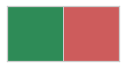

In [17]:
# définir ma propre palette
mypalette = ['seagreen', 'indianred']
sns.set_palette(mypalette)
sns.palplot(sns.color_palette())

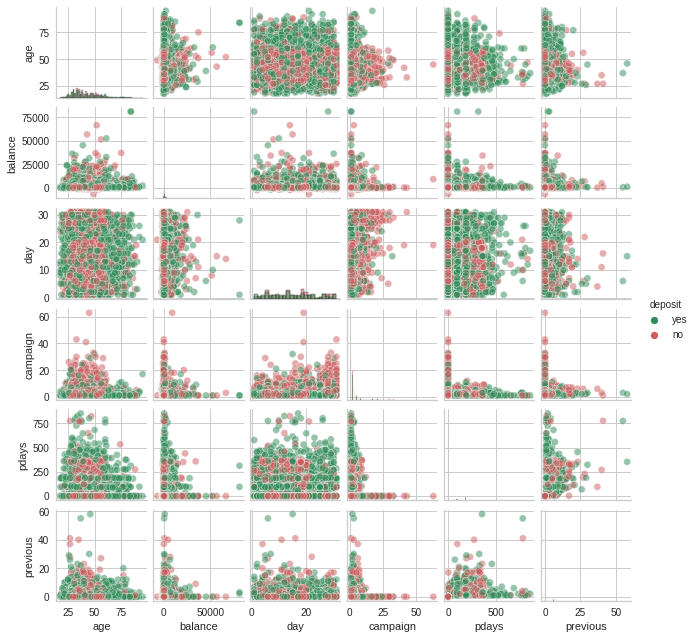

In [18]:
# Nuages ​​de points pour rechercher des relations et des histogrammes linéaires et non linéaires
sns.pairplot(traindf, diag_kind='hist',  hue= 'deposit', height=1.5, 
             diag_kws={"edgecolor":"k", "alpha":0.5},
             plot_kws={"alpha":0.5})

# Corrélations de Pearson, qui mesure la force d'une relation linéaire

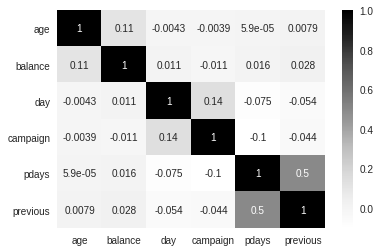

In [19]:
sns.heatmap(traindf.corr(method='pearson'), cmap="Greys", annot=True)

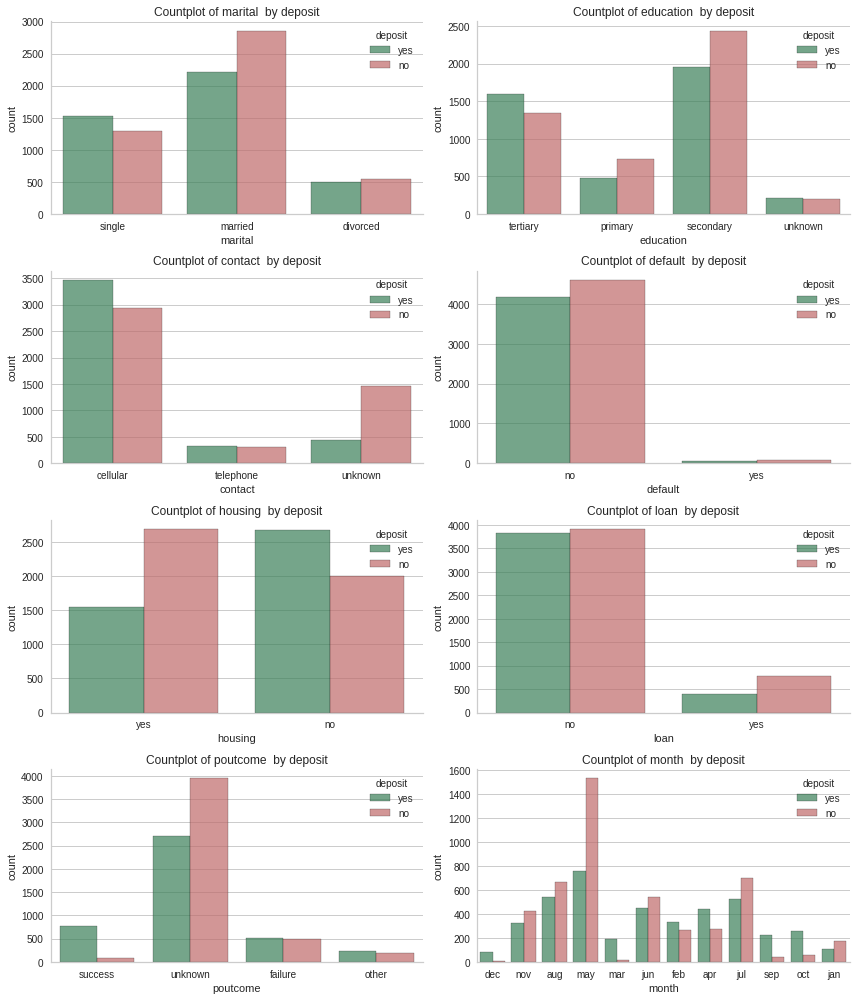

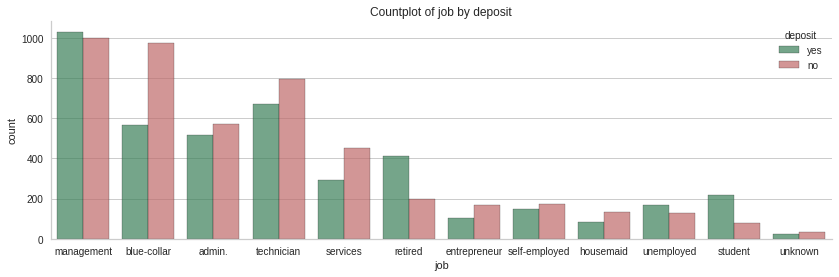

In [20]:
#barplots montrant la fréquence de chaque catégorie séparée par étiquette
plt.figure(figsize=[12,14])
features=["marital", "education", "contact", "default", "housing", "loan", "poutcome", "month"]
n=1
for f in features:
    plt.subplot(4,2,n)
    sns.countplot(x=f, hue='deposit', edgecolor="black", alpha=0.7, data=traindf)
    sns.despine()
    plt.title("Countplot of {}  by deposit".format(f))
    n=n+1
plt.tight_layout()
plt.show()

plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=traindf)
sns.despine()
plt.title("Countplot of job by deposit")
plt.show()

## 2- Prétraitement

In [21]:
# étiquette cible d'encodage
LE=LabelEncoder()
df['deposit']=LE.fit_transform(df.deposit.values)

#encoding categorical features
df=pd.get_dummies(df)

In [22]:
df

,age,balance,day,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,56,45,5,1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,41,1270,5,1,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,55,2476,5,1,-1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,54,184,5,2,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,20,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11158,39,733,16,4,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
11159,32,29,19,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11160,43,0,8,2,172,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [23]:
#partitioning again
for train_index, test_index in sss.split(df.drop("deposit",axis=1), df.deposit):
    traindf=df.loc[train_index]
    testdf= df.loc[test_index]

In [24]:
df

,age,balance,day,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,56,45,5,1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,41,1270,5,1,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,55,2476,5,1,-1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,54,184,5,2,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,1,20,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11158,39,733,16,4,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
11159,32,29,19,2,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11160,43,0,8,2,172,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [25]:
#partition x/y
xtrain=traindf.drop('deposit', axis=1)
ytrain=traindf.deposit

xtest=testdf.drop('deposit', axis=1)
ytest=testdf.deposit

# pipeline combinant transformateurs et estimateur

In [26]:
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())

In [27]:
# grille de recherche pour choisir la meilleure (combinaison de) hyperparamètres
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=10)

In [28]:
# validation croisée imbriquée combinant la recherche de grille (boucle interne) et le k-fold cv (boucle externe)
gs_knn_scores = cross_val_score(gs_knn, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

In [29]:
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())
 
#recherche de grille pour choisir la meilleure (combinaison de) hyperparamètres
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=10)

#validation croisée imbriquée combinant la recherche de grille (boucle intérieure) et le cv k-fold (boucle extérieure)
gs_knn_scores = cross_val_score(gs_knn, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit et fit avec le meilleur estimateurstimator
gs_knn.fit(xtrain, ytrain)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_knn_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(xtest, ytest)*100))

Train Accuracy:   76.0%
CV Mean Accuracy: 68.8%
Test Accuracy:    68.5%


## 4 - SVM

In [30]:
# pipeline combinant transformateurs et estimateur
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grille de recherche pour choisir la meilleure (combinaison de) hyperparamètres
r=[0.1,1,10]
pg_svm=[{'svc__C':r, 'svc__kernel':['linear']},
        {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=2)

# validation croisée imbriquée combinant la recherche de grille (boucle interne) et le k-fold cv (boucle externe)
gs_svm_scores = cross_val_score(gs_svm, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

# fit et fit avec le meilleur estimateur
gs_svm.fit(xtrain, ytrain)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_svm_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(xtest, ytest)*100))

Train Accuracy:   85.3%
CV Mean Accuracy: 69.4%
Test Accuracy:    68.7%


## 5 - Random Forest

In [31]:
rf= RandomForestClassifier(random_state=1)


pg_rf={'n_estimators': [100,200,400],'max_depth': [20,40,50,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=2)


gs_rf_scores = cross_val_score(gs_rf, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)


gs_rf.fit(xtrain, ytrain)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_rf_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(xtest, ytest)*100))

Train Accuracy:   97.4%
CV Mean Accuracy: 72.9%
Test Accuracy:    72.9%


## 6 - Gradient Boosting Decision Trees

In [32]:

xb= xgb.XGBClassifier(random_state=1)


pg_xb={'n_estimators':[100,200,400], 'max_depth':[20,40,50]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=2)


gs_xb_scores = cross_val_score(gs_xb, X=xtrain, y=ytrain, cv=5,scoring='accuracy', n_jobs=-1)

gs_xb.fit(xtrain, ytrain)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(xtrain, ytrain)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(xtrain, ytrain)*100))
print('CV Mean Accuracy: {0:.1f}%'.format(np.mean(gs_xb_scores)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(xtest, ytest)*100))

Train Accuracy:   99.8%
CV Mean Accuracy: 71.3%
Test Accuracy:    71.1%


# 7 - Brief talk about other metrics

In [33]:
# On uilisons le resultat de random forest
ypreds=gs_rf_best.predict(xtest)
print(confusion_matrix(ypreds ,ytest))
print(classification_report(ypreds ,ytest))

[[951 381]
 [224 677]]
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1332
           1       0.64      0.75      0.69       901

    accuracy                           0.73      2233
   macro avg       0.72      0.73      0.72      2233
weighted avg       0.74      0.73      0.73      2233



0.729064039408867

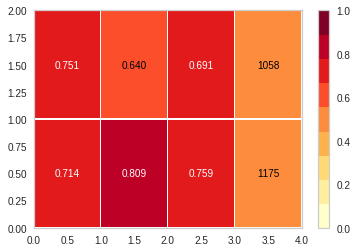

In [46]:
visualizer_cr = ClassificationReport(gs_rf_best, classes=["no", "yes"], support=True)
visualizer_cr.fit(xtrain, ytrain)
visualizer_cr.score(xtest, ytest)


0.7755173414121317

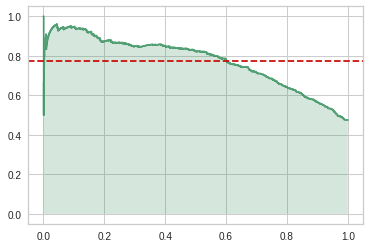

In [37]:
#Courbe de preccision
visualizer_pr = PrecisionRecallCurve(gs_rf_best)
visualizer_pr.fit(xtrain, ytrain)
visualizer_pr.score(xtest, ytest)


0.729064039408867

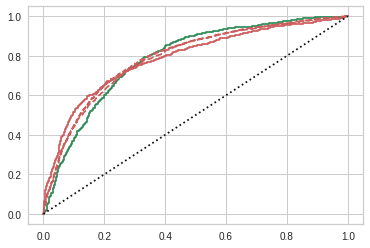

In [38]:
# Courbe ROC
visualizer_roc = ROCAUC(gs_rf_best, classes=["no", "yes"])
visualizer_roc.fit(xtrain, ytrain)
visualizer_roc.score(xtest, ytest)

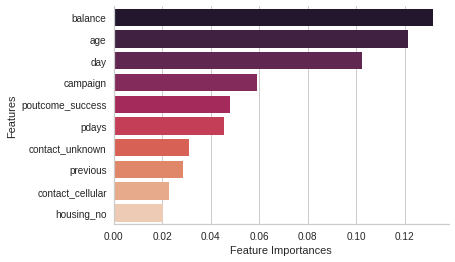

In [39]:
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=xtrain.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()